
# Classification of text documents using sparse features

This is an example showing how scikit-learn can be used to classify documents by
topics using a [Bag of Words approach](https://en.wikipedia.org/wiki/Bag-of-words_model). This example uses a
Tf-idf-weighted document-term sparse matrix to encode the features and
demonstrates various classifiers that can efficiently handle sparse matrices.

For document analysis via an unsupervised learning approach, see the example
script `sphx_glr_auto_examples_text_plot_document_clustering.py`.


In [15]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
#         Lars Buitinck
# License: BSD 3 clause

## Loading and vectorizing the 20 newsgroups text dataset

We define a function to load data from `20newsgroups_dataset`, which
comprises around 18,000 newsgroups posts on 20 topics split in two subsets:
one for training (or development) and the other one for testing (or for
performance evaluation). Note that, by default, the text samples contain some
message metadata such as `'headers'`, `'footers'` (signatures) and `'quotes'`
to other posts. The `fetch_20newsgroups` function therefore accepts a
parameter named `remove` to attempt stripping such information that can make
the classification problem "too easy". This is achieved using simple
heuristics that are neither perfect nor standard, hence disabled by default.



In [16]:
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

## Analysis of a bag-of-words document classifier

We will now train a classifier twice, once on the text samples including
metadata and once after stripping the metadata. For both cases we will analyze
the classification errors on a test set using a confusion matrix and inspect
the coefficients that define the classification function of the trained
models.

### Model without metadata stripping

We start by using the custom function `load_dataset` to load the data without
metadata stripping.



In [17]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.371s at 10.739MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.251s at 11.445MB/s
n_samples: 1353, n_features: 7831


In [24]:
feature_names

array(['00', '000', '0005', ..., 'zoo', 'zoology', 'zyeh'], dtype=object)

In [23]:
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [19]:
X_train

<2034x7831 sparse matrix of type '<class 'numpy.float64'>'
	with 183554 stored elements in Compressed Sparse Row format>

Our first model is an instance of the
:class:`~sklearn.linear_model.RidgeClassifier` class. This is a linear
classification model that uses the mean squared error on {-1, 1} encoded
targets, one for each possible class. Contrary to
:class:`~sklearn.linear_model.LogisticRegression`,
:class:`~sklearn.linear_model.RidgeClassifier` does not
provide probabilistic predictions (no `predict_proba` method),
but it is often faster to train.



In [20]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

We plot the confusion matrix of this classifier to find if there is a pattern
in the classification errors.



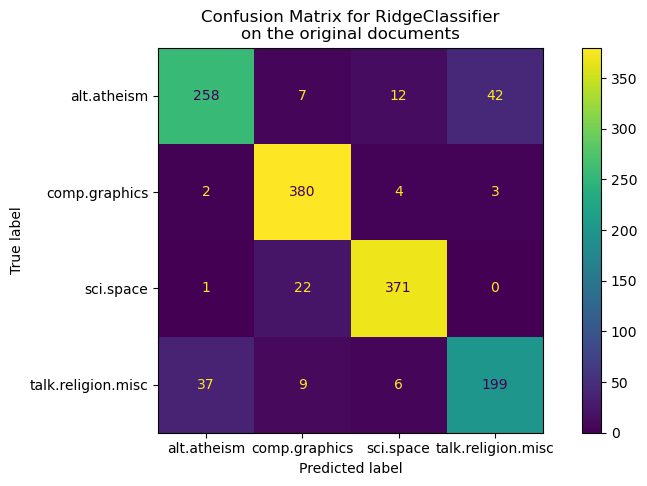

In [21]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [22]:
feature_names

array(['00', '000', '0005', ..., 'zoo', 'zoology', 'zyeh'], dtype=object)

The confusion matrix highlights that documents of the `alt.atheism` class are
often confused with documents with the class `talk.religion.misc` class and
vice-versa which is expected since the topics are semantically related.

We also observe that some documents of the `sci.space` class can be misclassified as
`comp.graphics` while the converse is much rarer. A manual inspection of those
badly classified documents would be required to get some insights on this
asymmetry. It could be the case that the vocabulary of the space topic could
be more specific than the vocabulary for computer graphics.

We can gain a deeper understanding of how this classifier makes its decisions
by looking at the words with the highest average feature effects:



top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


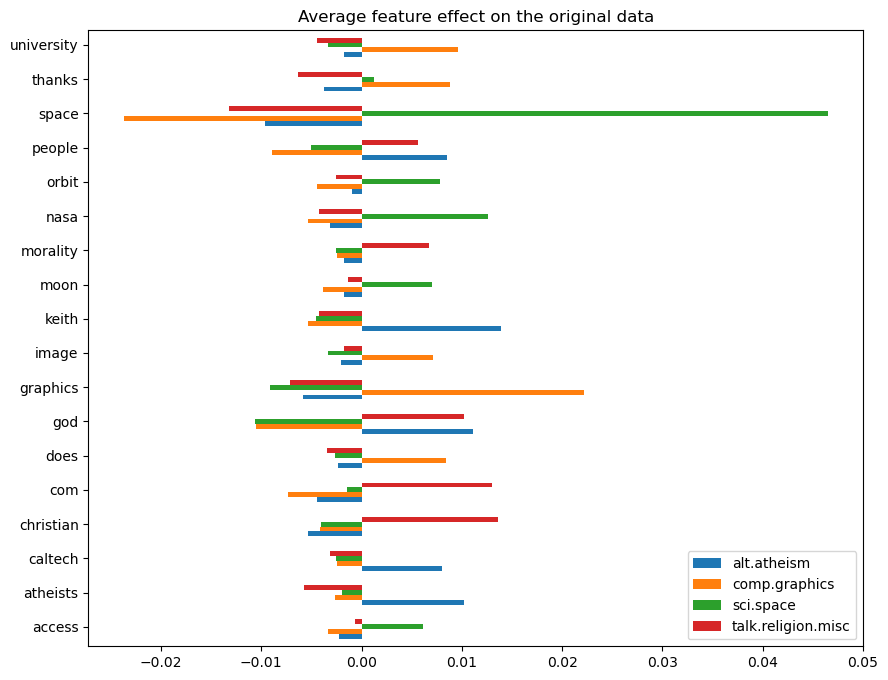

In [8]:
import numpy as np
import pandas as pd


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

We can observe that the most predictive words are often strongly positively
associated with a single class and negatively associated with all the other
classes. Most of those positive associations are quite easy to interpret.
However, some words such as `"god"` and `"people"` are positively associated to
both `"talk.misc.religion"` and `"alt.atheism"` as those two classes expectedly
share some common vocabulary. Notice however that there are also words such as
`"christian"` and `"morality"` that are only positively associated with
`"talk.misc.religion"`. Furthermore, in this version of the dataset, the word
`"caltech"` is one of the top predictive features for atheism due to pollution
in the dataset coming from some sort of metadata such as the email addresses
of the sender of previous emails in the discussion as can be seen below:



In [9]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

for doc in data_train.data:
    if "caltech" in doc:
        print(doc)
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

Such headers, signature footers (and quoted metadata from previous messages)
can be considered side information that artificially reveals the newsgroup by
identifying the registered members and one would rather want our text
classifier to only learn from the "main content" of each text document instead
of relying on the leaked identity of the writers.

### Model with metadata stripping

The `remove` option of the 20 newsgroups dataset loader in scikit-learn allows
to heuristically attempt to filter out some of this unwanted metadata that
makes the classification problem artificially easier. Be aware that such
filtering of the text contents is far from perfect.

Let us try to leverage this option to train a text classifier that does not
rely too much on this kind of metadata to make its decisions:



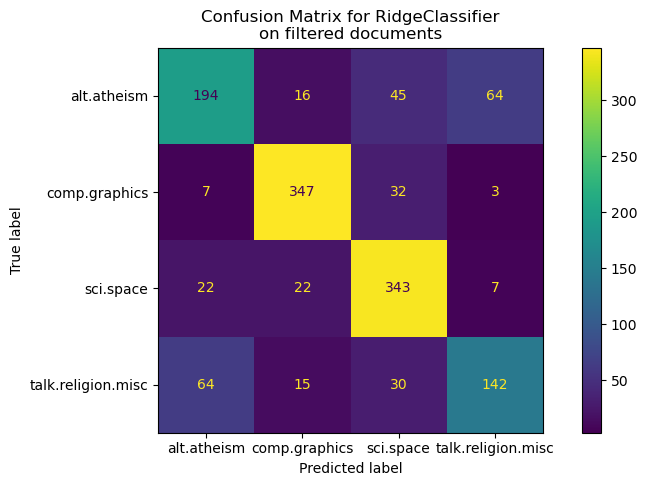

In [10]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

By looking at the confusion matrix, it is more evident that the scores of the
model trained with metadata were over-optimistic. The classification problem
without access to the metadata is less accurate but more representative of the
intended text classification problem.



top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


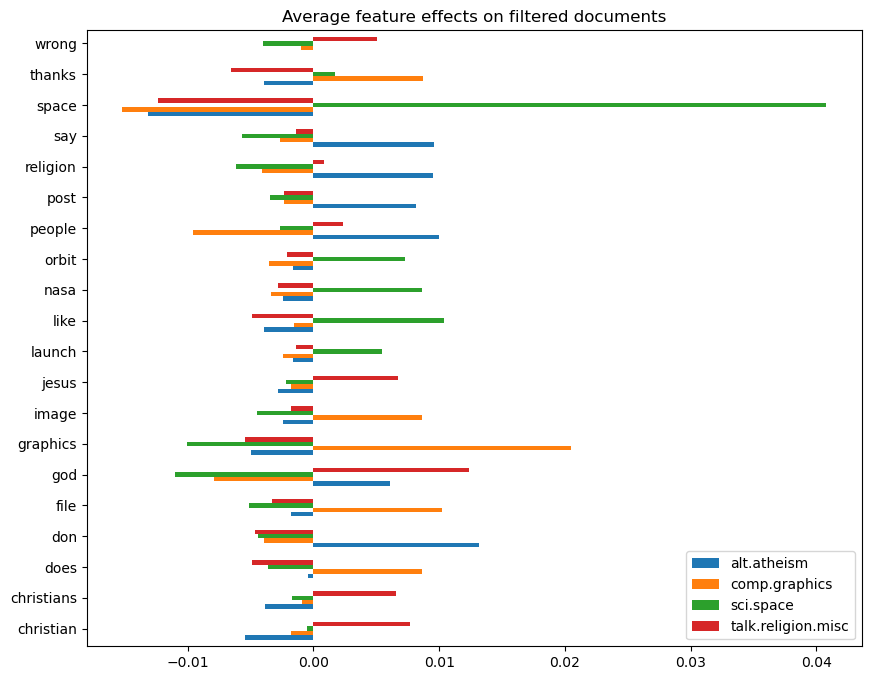

In [11]:
_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

In the next section we keep the dataset without metadata to compare several
classifiers.



## Benchmarking classifiers

Scikit-learn provides many different kinds of classification algorithms. In
this section we will train a selection of those classifiers on the same text
classification problem and measure both their generalization performance
(accuracy on the test set) and their computation performance (speed), both at
training time and testing time. For such purpose we define the following
benchmarking utilities:



In [12]:
from sklearn import metrics
from sklearn.utils.extmath import density


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

We now train and test the datasets with 8 different classification models and
get performance results for each model. The goal of this study is to highlight
the computation/accuracy tradeoffs of different types of classifiers for
such a multi-class text classification problem.

Notice that the most important hyperparameters values were tuned using a grid
search procedure not shown in this notebook for the sake of simplicity. See
the example script
`sphx_glr_auto_examples_model_selection_plot_grid_search_text_feature_extraction.py`  # noqa: E501
for a demo on how such tuning can be done.



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC

results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 0.215s
test time:  0.00101s
accuracy:   0.773
dimensionality: 5316
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.022s
test time:  0.001s
accuracy:   0.76
dimensionality: 5316
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.001s
test time:  1.52s
accuracy:   0.752

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 3.3s
test time:  0.044s
accuracy:   0.693

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train time:

## Plot accuracy, training and test time of each classifier

The scatter plots show the trade-off between the test accuracy and the
training and testing time of each classifier.



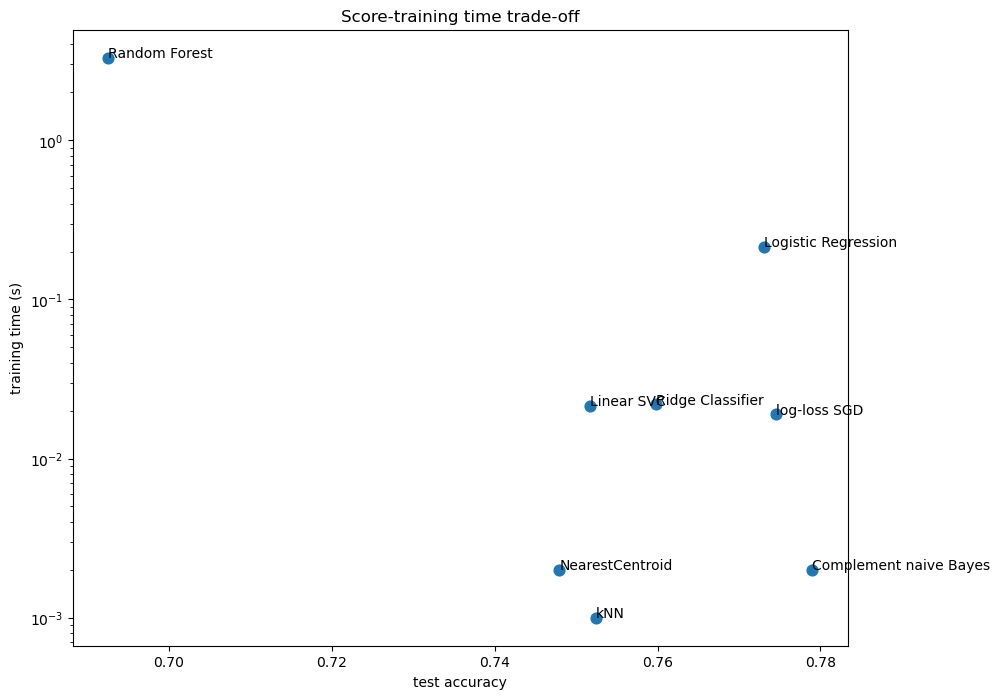

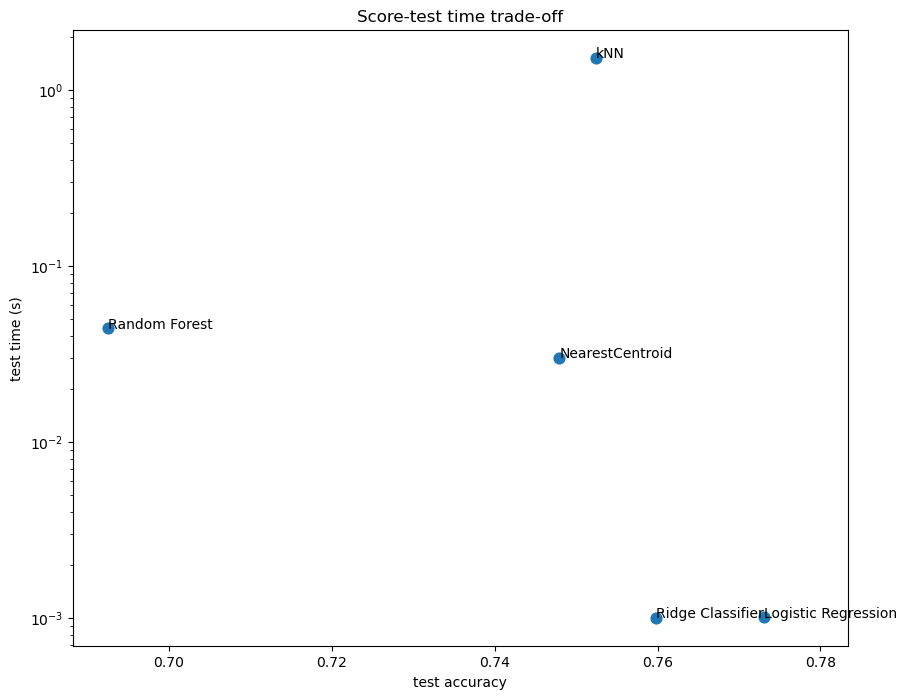

In [14]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))

The naive Bayes model has the best trade-off between score and
training/testing time, while Random Forest is both slow to train, expensive to
predict and has a comparatively bad accuracy. This is expected: for
high-dimensional prediction problems, linear models are often better suited as
most problems become linearly separable when the feature space has 10,000
dimensions or more.

The difference in training speed and accuracy of the linear models can be
explained by the choice of the loss function they optimize and the kind of
regularization they use. Be aware that some linear models with the same loss
but a different solver or regularization configuration may yield different
fitting times and test accuracy. We can observe on the second plot that once
trained, all linear models have approximately the same prediction speed which
is expected because they all implement the same prediction function.

KNeighborsClassifier has a relatively low accuracy and has the highest testing
time. The long prediction time is also expected: for each prediction the model
has to compute the pairwise distances between the testing sample and each
document in the training set, which is computationally expensive. Furthermore,
the "curse of dimensionality" harms the ability of this model to yield
competitive accuracy in the high dimensional feature space of text
classification problems.

